<a href="https://colab.research.google.com/github/eyaler/workshop/blob/master/output/nn_3_cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. How to train and test your network (CIFAR)

In [ ]:
%tensorflow_version 1.x
!pip install livelossplot
!pip install keras==2.2.5
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import Input, Model
from keras.layers import Dense, Dropout
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical
from livelossplot import PlotLossesKeras
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
!nvidia-smi -L

TensorFlow 1.x selected.


Using TensorFlow backend.


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-4a7679a0-4485-0695-45ca-b628a41d4de8)


In [ ]:
# set random seeds for more reproducible results
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(43)

In [ ]:
# load dataset
#(raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = mnist.load_data()
(raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = cifar10.load_data()
print(raw_x_train.shape, raw_y_train.shape)
if len(raw_x_train.shape)==4:
    raw_x_train = np.mean(raw_x_train, axis=-1, keepdims=True)
    raw_x_test = np.mean(raw_x_test, axis=-1, keepdims=True)
if len(raw_x_train.shape)==3:
    raw_x_train = np.expand_dims(raw_x_train, axis=-1)
    raw_x_test = np.expand_dims(raw_x_test, axis=-1)
train_size = len(raw_y_train)
test_size = len(raw_y_test)
xdim = raw_x_train.shape[1]
ydim = raw_x_train.shape[2]
print(raw_x_train.dtype, raw_y_train.dtype)

(50000, 32, 32, 3) (50000, 1)
float64 uint8


[[[ 61.33333333]
  [ 44.66666667]
  [ 47.        ]
  ...
  [132.66666667]
  [126.33333333]
  [125.        ]]

 [[ 18.66666667]
  [  0.        ]
  [  8.66666667]
  ...
  [ 88.66666667]
  [ 84.        ]
  [ 88.66666667]]

 [[ 23.33333333]
  [  7.66666667]
  [ 28.        ]
  ...
  [ 84.        ]
  [ 84.66666667]
  [ 74.66666667]]

 ...

 [[158.        ]
  [129.33333333]
  [128.33333333]
  ...
  [121.        ]
  [ 31.33333333]
  [ 35.66666667]]

 [[138.33333333]
  [112.66666667]
  [120.        ]
  ...
  [142.        ]
  [ 64.33333333]
  [ 56.66666667]]

 [[145.66666667]
  [130.33333333]
  [136.        ]
  ...
  [180.        ]
  [117.66666667]
  [ 95.66666667]]]
[6]


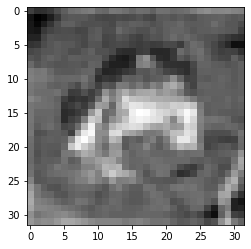

In [ ]:
print(raw_x_train[0])
print(raw_y_train[0])
if raw_x_train.shape[-1]==1:
    plt.imshow(raw_x_train[0][..., 0], cmap='gray')
else:
    plt.imshow(raw_x_train[0])

In [ ]:
print(np.min(raw_x_train), np.max(raw_x_train), np.median(raw_x_train))
print(np.unique(raw_y_train, return_counts=True))
print(np.unique(raw_y_test, return_counts=True))

0.0 255.0 116.33333333333333
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


In [ ]:
n_classes = len(np.unique(raw_y_test))
x_train, y_train = shuffle(raw_x_train, raw_y_train, random_state=44)
x_train = x_train.reshape((train_size, -1))/255
x_test = raw_x_test.reshape((test_size, -1))/255
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(raw_y_test, n_classes)
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

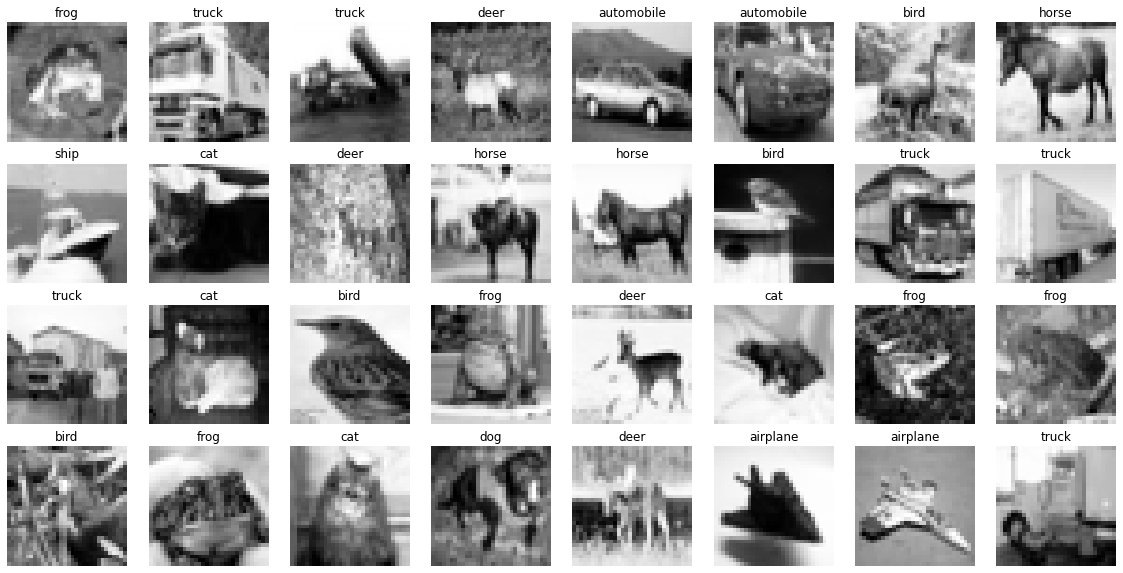

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

#helper function to plot in grids
def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(label_list[i])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

show_grid(raw_x_train[:32],4,8,label_list=[class_names[i] for i in np.squeeze(raw_y_train[:32])],show_labels=True,figsize=(20,10))

In [ ]:
dropout_prob = 0.5

def get_model():
    inputs = Input(shape=(xdim*ydim,))
    f = Dense(1024, activation='relu')(inputs)
    f = Dropout(dropout_prob)(f)
    f = Dense(1024, activation='relu')(f)
    f = Dropout(dropout_prob)(f)
    f = Dense(256, activation='relu')(f)
    f = Dropout(dropout_prob)(f)
    outputs = Dense(n_classes, activation='softmax')(f)
    return Model(inputs=inputs, outputs=outputs)

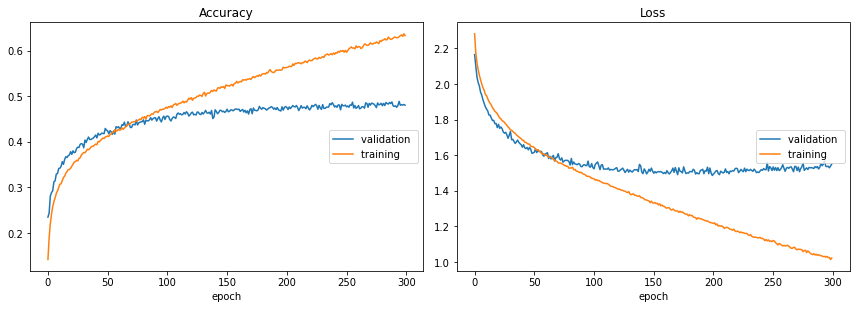

Accuracy
	validation       	 (min:    0.234, max:    0.489, cur:    0.480)
	training         	 (min:    0.141, max:    0.637, cur:    0.633)
Loss
	validation       	 (min:    1.486, max:    2.165, cur:    1.550)
	training         	 (min:    1.014, max:    2.282, cur:    1.022)


In [ ]:
model = get_model()
print(model.summary())
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=300, validation_split=0.2, callbacks=[PlotLossesKeras()])

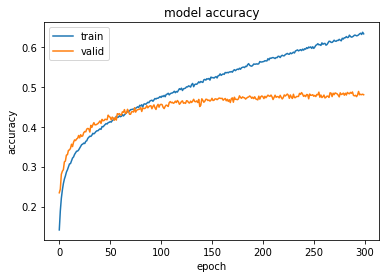

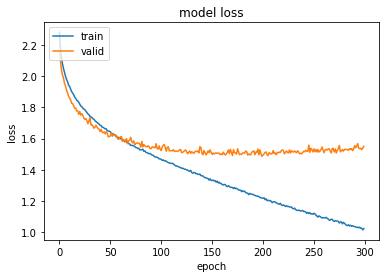

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
loss, acc = model.evaluate(x=x_test, y=y_test)
print(loss, acc)
targets = np.argmax(y_test, axis=-1)
probabilities = model.predict(x=x_test)
predictions = np.argmax(probabilities, axis=-1)
cm = confusion_matrix(y_true=targets, y_pred=predictions)
print(cm)

10000/10000 [==============================] - 0s 38us/step
1.5338816835403442 0.482
[[423  47  81  17 110  15  75  16 154  62]
 [ 15 642   7  24  21   8  69  12  60 142]
 [ 55  20 343  70 219  73 136  28  31  25]
 [ 24  32  80 254 130 151 223  39  16  51]
 [ 43  13 131  36 466  41 168  56  29  17]
 [ 15  14  90 136 133 397 125  59  10  21]
 [ 16  48  60  34  94  25 668  17  12  26]
 [ 23  21  40  60 146  73  51 526  14  46]
 [ 86 100  23  38  58  10  49  21 554  61]
 [ 21 207  17  33  28  14  59  27  47 547]]


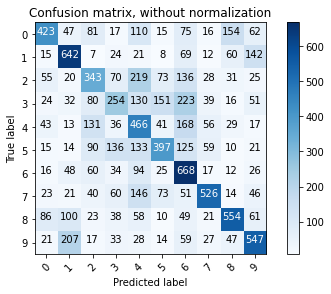

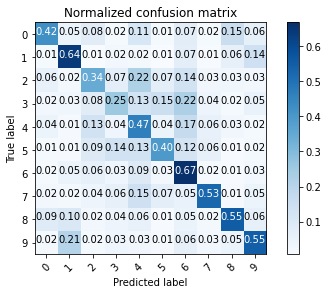

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    np.set_printoptions(precision=2)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

classes = np.arange(n_classes)
plot_confusion_matrix(cm, classes=classes)
plot_confusion_matrix(cm, classes=classes, normalize=True)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_true=targets, y_pred=predictions, labels=classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.59      0.42      0.49      1000
  automobile       0.56      0.64      0.60      1000
        bird       0.39      0.34      0.37      1000
         cat       0.36      0.25      0.30      1000
        deer       0.33      0.47      0.39      1000
         dog       0.49      0.40      0.44      1000
        frog       0.41      0.67      0.51      1000
       horse       0.66      0.53      0.58      1000
        ship       0.60      0.55      0.57      1000
       truck       0.55      0.55      0.55      1000

    accuracy                           0.48     10000
   macro avg       0.49      0.48      0.48     10000
weighted avg       0.49      0.48      0.48     10000



In [ ]:
# top errors
from sklearn.metrics import log_loss
max_probs = np.max(probabilities, axis=-1)
losses = [log_loss(y_true=y, y_pred=prob, eps=1e-7) for y,prob in zip(y_test,probabilities)]
print('loss\tindex\ttrue\tpredicted\tprobability')
top_errors = sorted(list(zip(losses, np.arange(test_size), [class_names[i] for i in targets], [class_names[i] for i in predictions], max_probs)), reverse=True)[:32]
titles = []
inds = []
for i,error in enumerate(top_errors):
    titles.append('%s -> %s'%(error[2],error[3]))
    inds.append(error[1])
    if i<10:
        print('%.04f\t%d\t%s\t%s\t\t%.04f'%error)
        #if raw_x_test.shape[-1]==1:
        #    plt.imshow(raw_x_test[error[1]][..., 0], cmap='gray')
        #else:
        #    plt.imshow(raw_x_test[error[1]])

loss	index	true	predicted	probability
1.4874	2323	ship	automobile		0.9989
1.4240	9856	dog	automobile		0.9892
1.3944	3438	truck	automobile		0.9991
1.2823	7348	bird	frog		0.9916
1.2693	2758	automobile	truck		0.9982
1.2689	9213	bird	horse		0.9945
1.2673	3496	dog	ship		0.5568
1.2399	5175	frog	automobile		0.9892
1.2191	4748	airplane	automobile		0.9896
1.2138	5496	deer	frog		0.9866


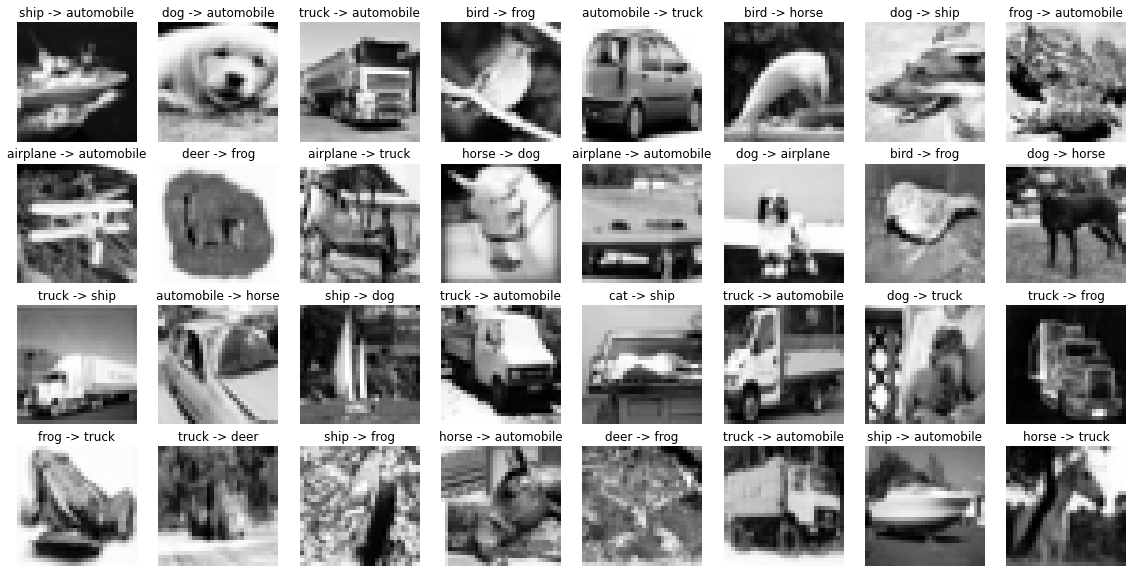

In [ ]:
show_grid(raw_x_test[inds[:32]],4,8,label_list=titles[:32],show_labels=True,figsize=(20,10))